In [69]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import tqdm

In [48]:
sigma = 1
gamma_list = np.arange(0.1, 10.1, 0.1)
N_sims = 200
N_data = 2000

In [302]:
def crlb(sigma, N):
    return sigma**2/N

def mse(s_pred, s_true):
    return np.mean(np.square(s_pred-s_true))

def mle_estimate(X):
    return np.mean(X)

def map_estimate(X, sigma, gamma):
    thresh = sigma**2/gamma
    ind_pos = X > thresh
    ind_neg = X < thresh
    
    s = np.zeros(X.shape)
    s[ind_pos] = X[ind_pos] - thresh
    s[ind_neg] = X[ind_neg] + thresh
    return s

def mmse_estimate(X, sigma, gamma):
    const = np.exp(X/gamma + sigma**2/2/(gamma**2))*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            np.exp(-X/gamma + sigma**2/2/(gamma**2))*norm.cdf((X-sigma**2/gamma)/sigma)
    
    expr1 = np.exp(X/gamma + sigma**2/2/(gamma**2))*((sigma/np.sqrt(2*np.pi))*\
            (0-np.exp(-1/2/(sigma**2)*(X+sigma**2/gamma)**2)) + (X + sigma**2/gamma) * norm.cdf((-X-sigma**2/gamma)/sigma))
    expr2 = -np.exp(-X/gamma + sigma**2/2/(gamma**2))*((sigma/np.sqrt(2*np.pi))*\
            (0-np.exp(-1/2/(sigma**2)*(X-sigma**2/gamma)**2)) - (X - sigma**2/gamma) * norm.cdf((X-sigma**2/gamma)/sigma))
    # print(const)
    # print(expr1)
    # print(expr2)
    return (expr1 + expr2)/const





In [303]:
mmse_estimate(x, sigma, gamma)

array([-16.47931003,  -3.33043126,   4.5782412 , ...,  12.91080475,
        -0.08623338,   4.54049849])

In [304]:
mle_estimate(x)

0.21883856769886897

In [305]:
map_estimate(x, sigma, gamma)

array([-1.64793100e+01, -3.33034885e+00,  4.57824075e+00, ...,
        1.29108048e+01,  6.65736185e-03,  4.54049795e+00])

In [306]:
s

array([-14.80309886,  -2.01130609,   5.96278432, ...,  13.50402075,
        -0.64394264,   7.10301212])

In [307]:
crlb = sigma**2/N_data
mse_mle_ret = []
mse_map_ret = []
mse_mmse_ret = []

for gamma in tqdm.tqdm(gamma_list):
    mse_mle = []
    mse_map = []
    mse_mmse = []

    for i in range(N_sims):
        n = np.random.randn(N_data)*sigma
        s = np.random.laplace(scale=gamma, size=N_data)
        x = n + s

        s_mle = mle_estimate(x)
        s_map = map_estimate(x, sigma, gamma)
        s_mmse = mmse_estimate(x, sigma, gamma)

        mse_mle.append(mse(s_mle, s))
        mse_map.append(mse(s_map, s))
        mse_mmse.append(mse(s_mmse, s))
    
    mse_mle_ret.append(np.mean(mse_mle))
    mse_map_ret.append(np.mean(mse_map))
    mse_mmse_ret.append(np.mean(mse_mmse))

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  5.98it/s]


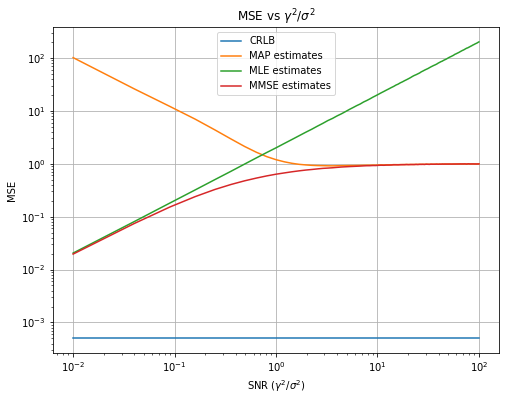

In [308]:
gamma_arr = np.array(gamma_list)**2/(sigma**2)

fig = plt.figure(figsize=(8,6))
plt.plot(gamma_arr, np.repeat(crlb, len(gamma_arr)), label="CRLB")
plt.plot(gamma_arr, mse_map_ret, label="MAP estimates")
plt.plot(gamma_arr, mse_mle_ret, label="MLE estimates")
plt.plot(gamma_arr, mse_mmse_ret, label="MMSE estimates")
plt.legend()
plt.yscale("log")
plt.xscale("log")
plt.xlabel("SNR ($\gamma^{2}/\sigma^{2}$)")
plt.ylabel("MSE")
plt.grid(True)
plt.title("MSE vs $\gamma^{2}/\sigma^{2}$")
plt.show()

try using an image, then apply wavelet, then denoise using these estimates, then convert back

## Gradient ascent for gamma, sigma

In [496]:
def grad_gamma(X, gamma, sigma):
    N = len(X)
    
    num1 = -X/(gamma**2)*np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            sigma/(gamma**2)*np.exp(X/gamma)*1/np.sqrt(2*np.pi)*np.exp(-1/2*((-X-sigma**2/gamma)/sigma)**2)
    
    num2 = X/(gamma**2)*np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma) +\
            sigma/(gamma**2)*np.exp(-X/gamma)*1/np.sqrt(2*np.pi)*np.exp(-1/2*((X-sigma**2/gamma)/sigma)**2)
    
    denom = np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma)
    
    grad = -N/gamma - N*(sigma**2)/(gamma**3) + np.sum((num1 + num2)/denom)
    
    return grad

def grad_sigma(X, gamma, sigma):
    N = len(X)
    
    num1 = 1/np.sqrt(2*np.pi)*(X/(sigma**2)-1/gamma)*np.exp(X/gamma)*np.exp(-1/2*((-X-sigma**2/gamma)/sigma)**2)
    
    num2 = -1/np.sqrt(2*np.pi)*(X/(sigma**2)+1/gamma)*np.exp(-X/gamma)*np.exp(-1/2*((X-sigma**2/gamma)/sigma)**2)
    
    denom = np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma)
    
    grad = N*sigma/(gamma**2) + np.sum((num1 + num2)/denom)
    
    return grad
    
def ml_estimate_sigma_gamma(X, gamma_init, sigma_init, 
                            max_steps=200, step_size=0.001):
    gamma_curr = gamma_init
    gamma_curr_ = gamma_init
    gamma_list = []
    gamma_list.append(gamma_curr)

    sigma_curr = sigma_init
    sigma_curr_ = sigma_init
    sigma_list = []
    sigma_list.append(sigma_curr)

    for i in tqdm.tqdm(np.arange(max_steps)):
        for j in range(3):
            grad_gamma_ = grad_gamma(X, gamma_curr_, sigma_curr)
            # only update if gradients are not too small
            if np.abs(grad_gamma_) >= early_stopping_ratio*np.abs(gamma_curr_):
                gamma_curr_ = gamma_curr_ + step_size*grad_gamma_
            else:
                break
        gamma_curr = gamma_curr_
        gamma_list.append(gamma_curr)
        
        for j in range(3):        
            grad_sigma_ = grad_sigma(X, gamma_curr, sigma_curr_)
            # only update if gradients are not too small
            if np.abs(grad_sigma_) >= early_stopping_ratio*np.abs(sigma_curr_):
                sigma_curr_ = sigma_curr_ + step_size*grad_sigma_
            else:
                break
        sigma_curr = sigma_curr_
        sigma_list.append(sigma_curr)
    
    return gamma_curr, sigma_curr, gamma_list, sigma_list


In [502]:
sigma = 1
gamma = 5
n = np.random.randn(N_data)*sigma
s = np.random.laplace(scale=gamma, size=N_data)
x = n + s

In [500]:
sigma_init = sigma + np.random.randn()
while sigma_init < 0:
    sigma_init = sigma + np.random.randn()

print(sigma_init)

gamma_init = gamma + np.random.randn()
while gamma_init < 0:
    gamma_init = gamma + np.random.randn()

print(gamma_init)

1.636461860603365
5.391698337955077


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 585.52it/s]


0.942070322460952
4.9419369967505835


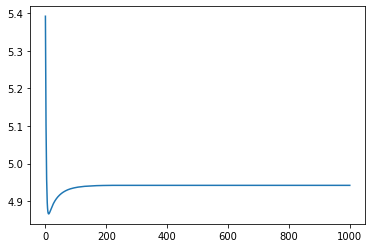

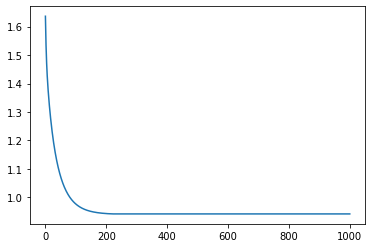

In [503]:
gamma_curr, sigma_curr, gamma_list, sigma_list = ml_estimate_sigma_gamma(x, gamma_init, sigma_init, max_steps=1000)
print(sigma_curr)
print(gamma_curr)

plt.plot(gamma_list)
plt.show()
plt.plot(sigma_list)
plt.show()

In [9]:
from scipy.optimize import line_search
import numpy as np
from scipy.stats import norm

In [370]:
def grad_gamma(init_point, X):
    gamma, sigma = init_point[0], init_point[1]
    N = len(X)
    
    num1 = -X/(gamma**2)*np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            sigma/(gamma**2)*np.exp(X/gamma)*1/np.sqrt(2*np.pi)*np.exp(-1/2*((-X-sigma**2/gamma)/sigma)**2)
    
    num2 = X/(gamma**2)*np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma) +\
            sigma/(gamma**2)*np.exp(-X/gamma)*1/np.sqrt(2*np.pi)*np.exp(-1/2*((X-sigma**2/gamma)/sigma)**2)
    
    denom = np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma)
    
    grad = -N/gamma - N*(sigma**2)/(gamma**3) + np.sum((num1 + num2)/denom)
    
    return grad

def grad_sigma(init_point, X):
    gamma, sigma = init_point[0], init_point[1]
    N = len(X)
    
    num1 = 1/np.sqrt(2*np.pi)*(X/(sigma**2)-1/gamma)*np.exp(X/gamma)*np.exp(-1/2*((-X-sigma**2/gamma)/sigma)**2)
    
    num2 = -1/np.sqrt(2*np.pi)*(X/(sigma**2)+1/gamma)*np.exp(-X/gamma)*np.exp(-1/2*((X-sigma**2/gamma)/sigma)**2)
    
    denom = np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) +\
            np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma)
    
    grad = N*sigma/(gamma**2) + np.sum((num1 + num2)/denom)
    
    return grad

def grad_total(init_point, X):
    v = np.array([grad_gamma(init_point, X), grad_sigma(init_point, X)])
    return -v

def ml_objective_gamma_sigma(init_point, X):
    gamma, sigma = init_point[0], init_point[1]
    N = len(X)
    
    sum1 = N*np.log(1/2/gamma)
    sum2 = N*sigma**2//2/(gamma**2)
    sum3 = np.log(np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) + np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma))
    sum3 = np.sum(sum3)
    
    return -(sum1 + sum2 + sum3)

In [371]:
def gradient_descent_line_search(gamma_init, sigma_init, X, steps=50, default_alpha=0.001):
    init_point = np.array([gamma_init, sigma_init])
    
    try:
        # first run outside loop
        curr_point = init_point
        old_fval = ml_objective_gamma_sigma(curr_point, X)
        d = grad_total(curr_point, X)
        delta = -d/np.linalg.norm(d)
        alpha, _, _, _, _, _ = line_search(ml_objective_gamma_sigma, grad_total, curr_point, delta, args=([X]))
        new_point = init_point + alpha*delta
        new_fval = ml_objective_gamma_sigma(new_point, X)
        curr_point = new_point

        for i in range(steps-1):
            d = grad_total(curr_point, X)
            delta = -d/np.linalg.norm(d)
            new_alpha, _, _, new_fval, old_fval, _ = line_search(ml_objective_gamma_sigma, grad_total, curr_point, delta, args=([X]), old_fval=new_fval, old_old_fval=old_fval)
            if new_alpha is not None:
                new_point = curr_point + new_alpha*delta
            else:
                new_point = curr_point + default_alpha*delta
            curr_point = new_point
        if curr_point[0] == np.nan or curr_point[1] == np.nan:
            return None, None
        return curr_point[0], curr_point[1]
    except Exception as e:
        print(e)
        return None, None

In [372]:
sigma = 1
gamma_list = np.arange(0.1, 10.1, 0.1)
N_sims = 200
N_data = 2000
gamma = 5
n = np.random.randn(N_data)*sigma
s = np.random.laplace(scale=gamma, size=N_data)
X = n + s

In [373]:
gamma_init = gamma + np.random.randn()
while gamma_init < 0:
    gamma_init = gamma + np.random.randn()
    
sigma_init = sigma + np.random.randn()
while sigma_init < 0:
    sigma_init = sigma + np.random.randn()
print(gamma_init, sigma_init)

5.898705373493206 1.6131167000090305


In [374]:
gamma_est, sigma_est = gradient_descent_line_search(gamma_init, sigma_init, X, steps=50, default_alpha=0.001)

/home/anvuong/miniconda3/envs/tf2/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


In [375]:
gamma_est, sigma_est

(5.124174427044595, 0.8482489636656858)

In [376]:
np.mean([1,2,np.nan])

nan

In [321]:
z = np.array([1,2,3,np.nan])

In [323]:
np.isnan(z)

array([False, False, False,  True])

In [324]:
[[0.1, 0.9936469301927782, 0.9936469301927782, 0.04018490916874412], [1.1, 0.9935080592453627, 0.9935080592453627, 0.6756340721895928], [2.1, 0.9935298775824565, 0.9935298775824565, 0.8640112748765005], [3.1, 0.9935695130722207, 0.9935695130722207, 0.9273072121241852], [4.1, 0.9940401962558691, 0.9940401962558691, 0.953717175844004], [5.1, 0.9939884729883532, 0.9939884729883532, 0.9706358414338454], [6.1, 0.9938971609540923, 0.9938971609540923, 0.9789984761855114], [7.1, 0.9933434098496111, 0.9933434098496111, 0.9932721427427725], [8.1, 0.993629067787905, 0.993629067787905, 10.34710207057684], [9.1, 0.9933759109881551, 0.9933759109881551, 1.0359807207836191]]

In [327]:
from helpers import *

In [377]:
n = np.random.randn(N_data)*sigma
s = np.random.laplace(scale=gamma, size=N_data)
x = n + s

s_mle = mle_estimate(x)
s_map = map_estimate(x, sigma, gamma)
s_mmse = mmse_estimate(x, sigma, gamma)

In [329]:
s_mle.shape

(2000, 200)

In [331]:
np.mean(s_mle, axis=0)

(200,)

In [335]:
gamma_init

3.982241310307936

In [378]:
while gamma_est_ is None or gamma_est_ == np.nan or gamma_est_ < 0 or sigma_est_ is None or sigma_est_ == np.nan or sigma_est_ < 0:
    # estimate hyper parameters
    gamma_init = gamma + np.random.randn()
    while gamma_init <= 0:
        gamma_init = gamma + np.random.randn()

    sigma_init = sigma + np.random.randn()
    while sigma_init <= 0:
        sigma_init = sigma + np.sqrt(0.1)*np.random.randn() # variance 0.1

    gamma_est_, sigma_est_ = gradient_descent_line_search(gamma_init, sigma_init, x, steps=50, default_alpha=0.001)

/tmp/ipykernel_1602/3150404770.py:41: RuntimeWarning: invalid value encountered in log
  sum1 = N*np.log(1/2/gamma)
/home/anvuong/miniconda3/envs/tf2/lib/python3.10/site-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/tmp/ipykernel_1602/3150404770.py:43: RuntimeWarning: divide by zero encountered in log
  sum3 = np.log(np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) + np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma))
/tmp/ipykernel_1602/3150404770.py:14: RuntimeWarning: divide by zero encountered in divide
  grad = -N/gamma - N*(sigma**2)/(gamma**3) + np.sum((num1 + num2)/denom)
/tmp/ipykernel_1602/3150404770.py:29: RuntimeWarning: invalid value encountered in divide
  grad = N*sigma/(gamma**2) + np.sum((num1 + num2)/denom)
/tmp/ipykernel_1602/3150404770.py:14: RuntimeWarning: invalid value encountered in divide
  grad = -N/gamma - N*(sigma**2)/(gamm

In [379]:
sigma_init, gamma_init

(2.0050876636625903, 6.3875904365304415)

In [380]:
gamma_est_, sigma_est_

(5.338521770045988, 0.6060639198181407)

In [343]:
gradient_descent_line_search(gamma_init, sigma_init, x, steps=50, default_alpha=0.001)

(None, None)

In [386]:
obj_min = np.inf
gamma_est, sigma_est = -1, -1
# run MML estimations a few times and pick the pair that maximize the likelihood
for i in range(5):
    print(i)
    gamma_est_, sigma_est_ = -1, -1
    while gamma_est_ is None or gamma_est_ == np.nan or gamma_est_ < 0 or sigma_est_ is None or sigma_est_ == np.nan or sigma_est_ < 0:
        # estimate hyper parameters
        gamma_init = gamma + np.random.randn()
        while gamma_init <= 0:
            gamma_init = gamma + np.random.randn()

        sigma_init = sigma + np.random.randn()
        while sigma_init <= 0:
            sigma_init = sigma + np.sqrt(0.1)*np.random.randn() # variance 0.1

        gamma_est_, sigma_est_ = gradient_descent_line_search(gamma_init, sigma_init, x, steps=50, default_alpha=0.001)
    obj = ml_objective_gamma_sigma([gamma_est_, sigma_est_], x)
    if obj < obj_min:
        print(obj)
        obj_min = obj
        gamma_est, sigma_est = gamma_est_, sigma_est_
    print(gamma_init, sigma_init)
    print(gamma_est, sigma_est)

0
6748.170722693054
5.126375555419514 0.36056843806479055
5.33850000518974 0.6060586750163264
1


/tmp/ipykernel_1602/3150404770.py:41: RuntimeWarning: invalid value encountered in log
  sum1 = N*np.log(1/2/gamma)
/tmp/ipykernel_1602/3150404770.py:43: RuntimeWarning: divide by zero encountered in log
  sum3 = np.log(np.exp(X/gamma)*norm.cdf((-X-sigma**2/gamma)/sigma) + np.exp(-X/gamma)*norm.cdf((X-sigma**2/gamma)/sigma))
/tmp/ipykernel_1602/3150404770.py:14: RuntimeWarning: invalid value encountered in divide
  grad = -N/gamma - N*(sigma**2)/(gamma**3) + np.sum((num1 + num2)/denom)
/tmp/ipykernel_1602/3150404770.py:29: RuntimeWarning: invalid value encountered in divide
  grad = N*sigma/(gamma**2) + np.sum((num1 + num2)/denom)


5.534458029431249 1.2277367636551049
5.33850000518974 0.6060586750163264
2
6748.168386381218
5.019532205908498 0.9700396333589878
5.337946280395406 0.6060031365756463
3
4.83940301110659 1.8883130800733885
5.337946280395406 0.6060031365756463
4
4.328871819874208 1.3026046833249803
5.337946280395406 0.6060031365756463


In [384]:
gamma_est, sigma_est

(5.3383394012976195, 0.6060299605489308)

In [435]:
def mle_gamma(X):
    return np.mean(np.abs(X), axis=0)

def crlb_gamma(N, gamma):
    FIM = N/(gamma**2)
    return 1/FIM

In [436]:
mle_gamma(x)

10.941723650803285

In [437]:
gamma_hats = []
gamma = 10
crlb_ = crlb_gamma(200, gamma)
for N_data in tqdm.tqdm(range(10, 1000, 10)):
    gamma_hats_ = []
    for sim in range(200):
        x = np.random.laplace(scale=gamma, size=200)
        crlbs_.append(crlb_gamma(x, gamma))
        gamma_hats_.append((mle_gamma(x) - gamma)**2)
    gamma_hats.append(np.mean(gamma_hats_))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 261.66it/s]


In [438]:
import matplotlib.pyplot as plt

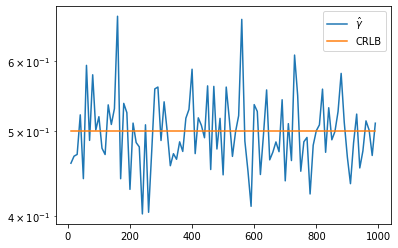

In [439]:
plt.plot(range(10, 1000, 10), gamma_hats, label="$\hat{\gamma}$")
plt.plot(range(10, 1000, 10), np.ones(len(gamma_hats))*crlb_, label="CRLB")
plt.yscale("log")
plt.legend()
plt.show()

In [414]:
gamma_hat = mle_gamma(s)

In [415]:
gamma_hat

49.8676999615042

In [416]:
crlb_gamma(x, 50)

0.125012501250125

In [417]:
np.mean(np.abs(x))

49.804069999328505

In [ ]:
np.square